In [1]:
# Author: Proloy das <pd640@nmr.mgh.harvard.edu>
# License: BSD (3-clause)

%matplotlib inline

In [2]:
import numpy as np
import eelbrain
import mne
from mne.datasets import sample
from codetiming import Timer
from matplotlib import pyplot as plt
from eelbrain import save

In [3]:
data_path = sample.data_path()
fwd_fname = data_path + '/MEG/sample/sample_audvis-meg-eeg-oct-6-fwd.fif'
ave_fname = data_path + '/MEG/sample/sample_audvis-ave.fif'
cov_fname = data_path + '/MEG/sample/sample_audvis-cov.fif'
subjects_dir = data_path + '/subjects'
condition = 'Left Auditory'
subject = 'sample'

## Simulate raw data

In [4]:
info = mne.io.read_info(ave_fname)
info['sfreq'] = 250.
tstep = 1 / info['sfreq']
forward = mne.read_forward_solution(fwd_fname)
src = forward['src']
noise_cov = mne.read_cov(cov_fname)

### Region to activate<br>
To select a region to activate, we use the caudal middle frontal to grow a region of interest.

In [5]:
roi = 'caudalmiddlefrontal'
rois = ['transversetemporal', 'precentral']
hemis = ['lh', 'rh']
selected_labels = [mne.read_labels_from_annot(
                                        subject,
                                        regexp=f'{roi}-{hemi}',
                                        subjects_dir=subjects_dir
                                             )[0] 
                   for roi, hemi in zip(rois, hemis)]
location = 'center'  # Use the center of the region as a seed.
extent = 10.  # Extent in mm of the region.
labels = [mne.label.select_sources(
    subject, selected_label, location=location, extent=extent,
    subjects_dir=subjects_dir) for selected_label in selected_labels]

### Define the time course of the activity for each source of the region to activate.
Here we use two AR processes: one slow (3Hz), and one fast oscillations(12Hz).

In [6]:
from purdonlabmeeg._temporal_dynamics_utils.tests._generate_data import ARData

ntimes = int(np.round(info['sfreq'] * 10.))
slow_data = ARData(ntimes, noise_var=0.01,
                   coeffs=[2*np.cos(2*np.pi*1.6/info['sfreq']),
                           -0.9999999],
                   num_prev=2)
fast_data = ARData(ntimes, noise_var=0.01,
                   coeffs=[2*np.cos(2*np.pi*12/info['sfreq']),
                           -0.9996],
                   num_prev=2)

source_time_series1 = 15e-9 * slow_data.y / slow_data.y.std()
source_time_series2 = 5e-9 * fast_data.y / fast_data.y.std()
source_time_serieses = (source_time_series1, source_time_series2)

using the njit one


### Define when the activity occurs using events.<br>
The first column is the sample of the event, the second is not used, and the third is the event id. Here the events occur every 200 samples.

In [7]:
n_events = 10
events = np.zeros((n_events, 3))
events[:, 0] = 100 + (ntimes + 100) * np.arange(n_events)  # Events sample.
events[:, 2] = 1  # All events have the sample id.

### Create simulated source activity.<br>
Here we use a `SourceSimulator` whose add_data method is key. It specified where (label), what (source_time_series), and when (events) an event type will occur.

In [8]:
source_simulator = mne.simulation.SourceSimulator(src, tstep=tstep)
for label, source_time_series  in zip(labels, source_time_serieses):
    source_simulator.add_data(label, source_time_series, events)

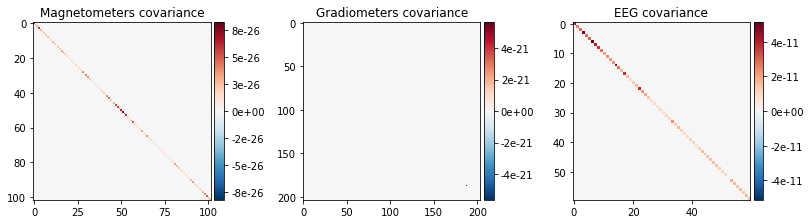

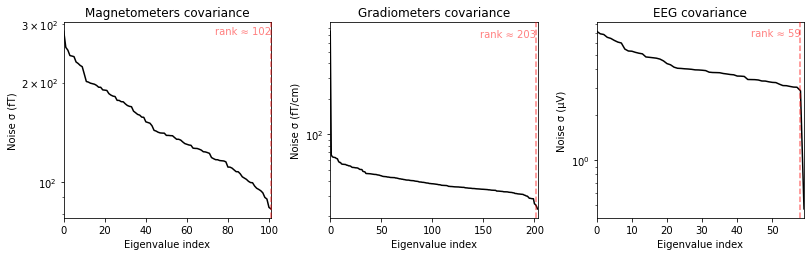

(<Figure size 820.8x266.4 with 6 Axes>, <Figure size 820.8x266.4 with 3 Axes>)

In [9]:
noise_cov.data[:] *= np.eye(noise_cov.data.shape[0])

noise_cov.plot(info)

### Project the source time series to sensor space and add some noise.<br>
The source simulator can be given directly to the simulate_raw function.

In [10]:
raw = mne.simulation.simulate_raw(info, source_simulator, forward=forward)
# raw = raw_orig
cov = mne.make_ad_hoc_cov(raw.info)
raw_orig = raw.copy()
mne.simulation.add_noise(raw, noise_cov, random_state=0)

<RawArray | 376 x 26000 (104.0 s), ~77.9 MB, data loaded>

### extract the epochs and form evoked object

/homes/1/pd640/Workspace/.conda/envs/eelbrain/lib/python3.8/site-packages/mne/viz/evoked.py:537: MatplotlibDeprecationWarning: The 'rectprops' parameter of __init__() has been renamed 'props' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax._span_selector = SpanSelector(
/homes/1/pd640/Workspace/.conda/envs/eelbrain/lib/python3.8/site-packages/mne/viz/evoked.py:537: MatplotlibDeprecationWarning: The 'rectprops' parameter of __init__() has been renamed 'props' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax._span_selector = SpanSelector(
/homes/1/pd640/Workspace/.conda/envs/eelbrain/lib/python3.8/site-packages/mne/viz/evoked.py:537: MatplotlibDeprecationWarning: The 'rectprops' parameter of __init__() has been renamed 'props' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax._span_selector = SpanSelector(


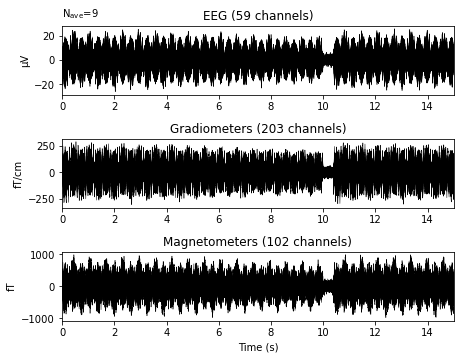

In [11]:
raw = raw.filter(1., None)
events = mne.find_events(raw)
epochs = mne.Epochs(raw, events, 1, tmin=-0.00, tmax=10.0, baseline=None)
epochs.load_data()
# epochs = epochs.filter(1., None)
evoked = epochs.average()
fig = evoked.plot()

Crop timepoints of interest, and pick only the EEG channels!

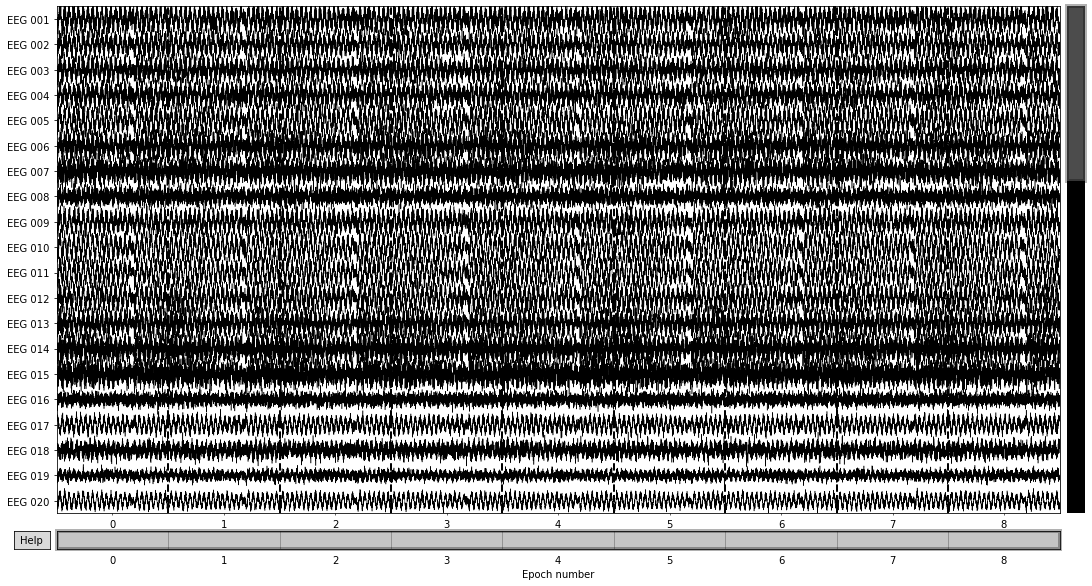

In [12]:
epochs = epochs.pick_types(eeg=True, meg=False)
epochs = epochs.drop_channels('EEG 052')
fig = epochs.plot()

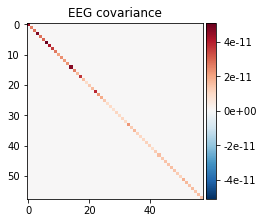

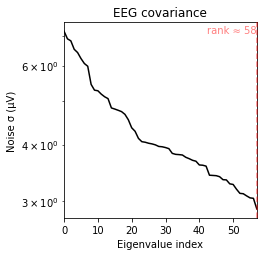

(<Figure size 273.6x266.4 with 2 Axes>, <Figure size 273.6x266.4 with 1 Axes>)

In [13]:
noise_cov.plot(epochs.info)

In [14]:
from purdonlabmeeg import OCA

for ii in [0]: # range(0, len(epochs)):
    epoch = epochs[0]
    ocacv = OCA.fit_cv(epoch, [1, 2, 3, 4, 5], picks=None, start=None, stop=None,
                       max_iter=200, initial_guess=None,
                       scalar_alpha=True, update_sigma2=True,
                       tol=1e-4, verbose=None)
    save.pickle(ocacv, f'results/oca-10s-epoch{ii}-cv')

using the njit one
using the njit one
using the njit one
using the njit one
using the njit one
using the njit one
using the njit one
using the njit one
using the njit one
using the njit one
using the njit one
using the njit one
using the njit one
using the njit one
using the njit one
using the njit one


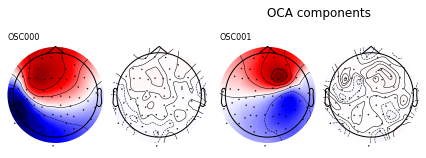

In [15]:
fig = ocacv.plot_topomaps()

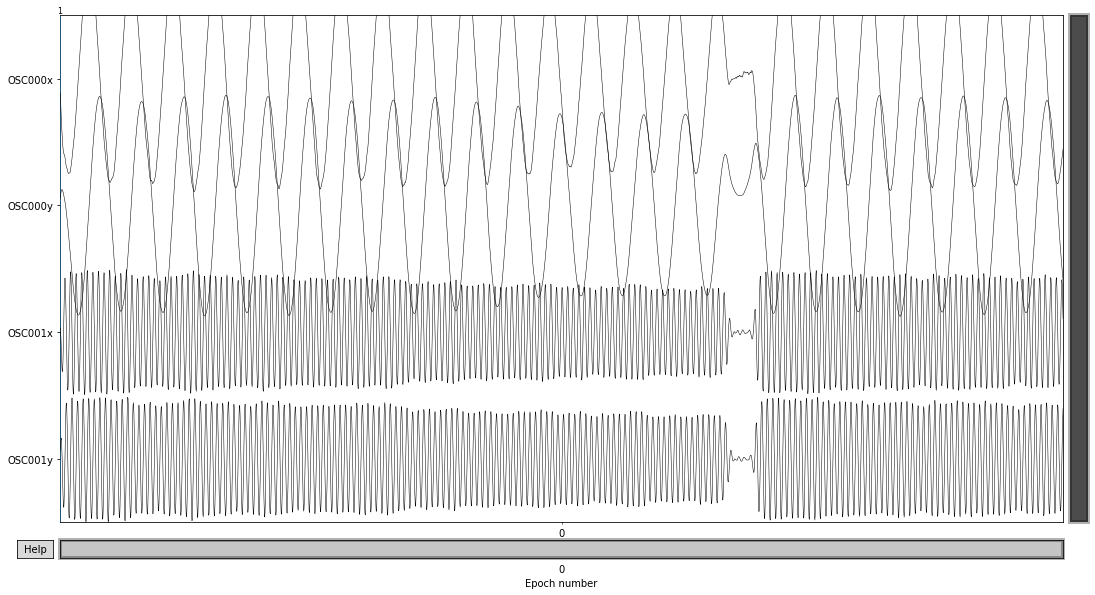

In [16]:
fig = ocacv.plot_sources(epoch)

So, the main culprit was the noise covariance (definitely) and temporal update.

fixed the tempral update, now it's solving a block tri-diagonal inverse problem partially to get the mean and covarince matrices (Generalized Kalman Smoothing!).   

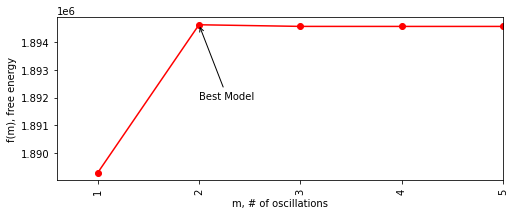

In [17]:
fig = ocacv.plot_cv()

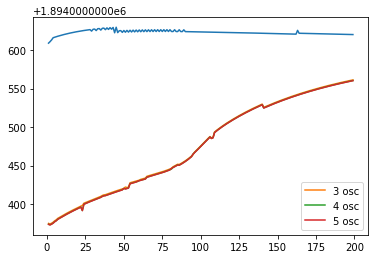

In [18]:
fig, ax = plt.subplots()
ax.plot(ocacv._free_energy)
for i in ocacv._rest_ocas[:-1]:
    ax.plot(i._free_energy, label=f'{len(i)} osc')
ax.legend()

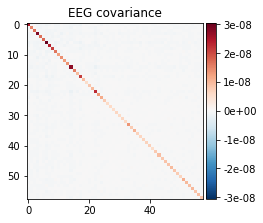

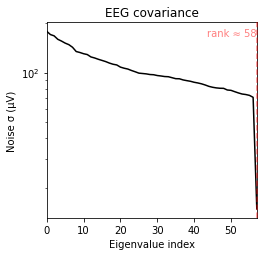

(<Figure size 273.6x266.4 with 2 Axes>, <Figure size 273.6x266.4 with 1 Axes>)

In [19]:
cov = mne.Covariance(ocacv.noise_var, ocacv.info.ch_names, 
                     bads=None, projs=[], nfree=1, 
                     eig=None, eigvec=None, method='custom',
                     loglik=None, verbose=None)
# epoch.info
cov.plot(ocacv.info)